In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import gli_calc

In [2]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [3]:
%config InlineBackend.figure_format = "retina"

In [ ]:
data_path = pd.read_csv(
    "/Users/mxposed/Documents/data_paths/ssc.csv",
    index_col=0
).value["clinical_data"]

In [5]:
data_path = os.path.join(data_path, "processed")

In [6]:
os.makedirs("plots", exist_ok=True)

# Plot PFT trends

Here we want to plot historical PFT trends from SSc registry + PFT values from SSc study and overlay it with patient therapy, specificaly MMF start date

## 1. Load sample and timeline data

In [7]:
samples = pd.read_csv("../00all-samples.csv")

Take only our samples

In [8]:
samples = samples.loc[samples.Study.eq("this"), :].copy()

In [9]:
samples["Patient_id"] = samples.Sample

Strip `_followup` to get Redcap patient ids

In [10]:
samples.Patient_id = samples.Patient_id.str.replace("_followup$", "", regex=True)

Number of unique patients among our samples

In [11]:
samples.Patient_id.nunique()

14

In [12]:
date_info = pd.read_csv(os.path.join(data_path, "05_date_info.csv"), index_col=0)

In [13]:
date_info.date = pd.to_datetime(date_info.date)

In [14]:
clin_info = pd.read_csv(os.path.join(data_path, "03_clin_info.csv"), index_col=0)

In [15]:
pt_info = pd.read_csv(os.path.join(data_path, '01_pt_info.csv'), index_col=0)

## 2. Load registry PFT data

This was already processed using new GLI calculator by Alec

In [16]:
registry = pd.read_csv(os.path.join(data_path, "..", "scrna_seq_v2.csv"))

### 2.1 Recalculate % predicted using height from our patient data

Set height from our clinical data and recalculate % predicted. Height in registry is from different timepoint.

In [17]:
registry['sex'] = registry.gender.str.lower()

In [18]:
registry["registry_number"] = registry["case_number"].str.extract(r"(\d{4})")

In [19]:
pt_info["registry_number"] = pt_info.study_code.str.extract(r"(\d{4})")

In [20]:
pt_info_registry = pt_info.loc[pt_info.registry_number.notna()].set_index('registry_number')

In [21]:
registry['height'] = pt_info_registry.height[registry.registry_number].values

In [22]:
registry['fev1_pred_new'] = gli_calc.fev1_percent_predicted(
    registry.sex.str.lower(),
    registry.Age,
    registry.height,
    registry.FEV1
)

In [23]:
registry['fvc_pred_new'] = gli_calc.fvc_percent_predicted(
    registry.sex.str.lower(),
    registry.Age,
    registry.height,
    registry.FVC
)

In [24]:
# We do not have raw DLCO measurements

# registry['dlco_pred_new'] = gli_calc.dlco_percent_predicted(
#     registry.sex.str.lower(),
#     registry.Age,
#     registry.height,
#     registry.DLCO
# )

<Axes: xlabel='predicted_FEV1', ylabel='fev1_pred_new'>

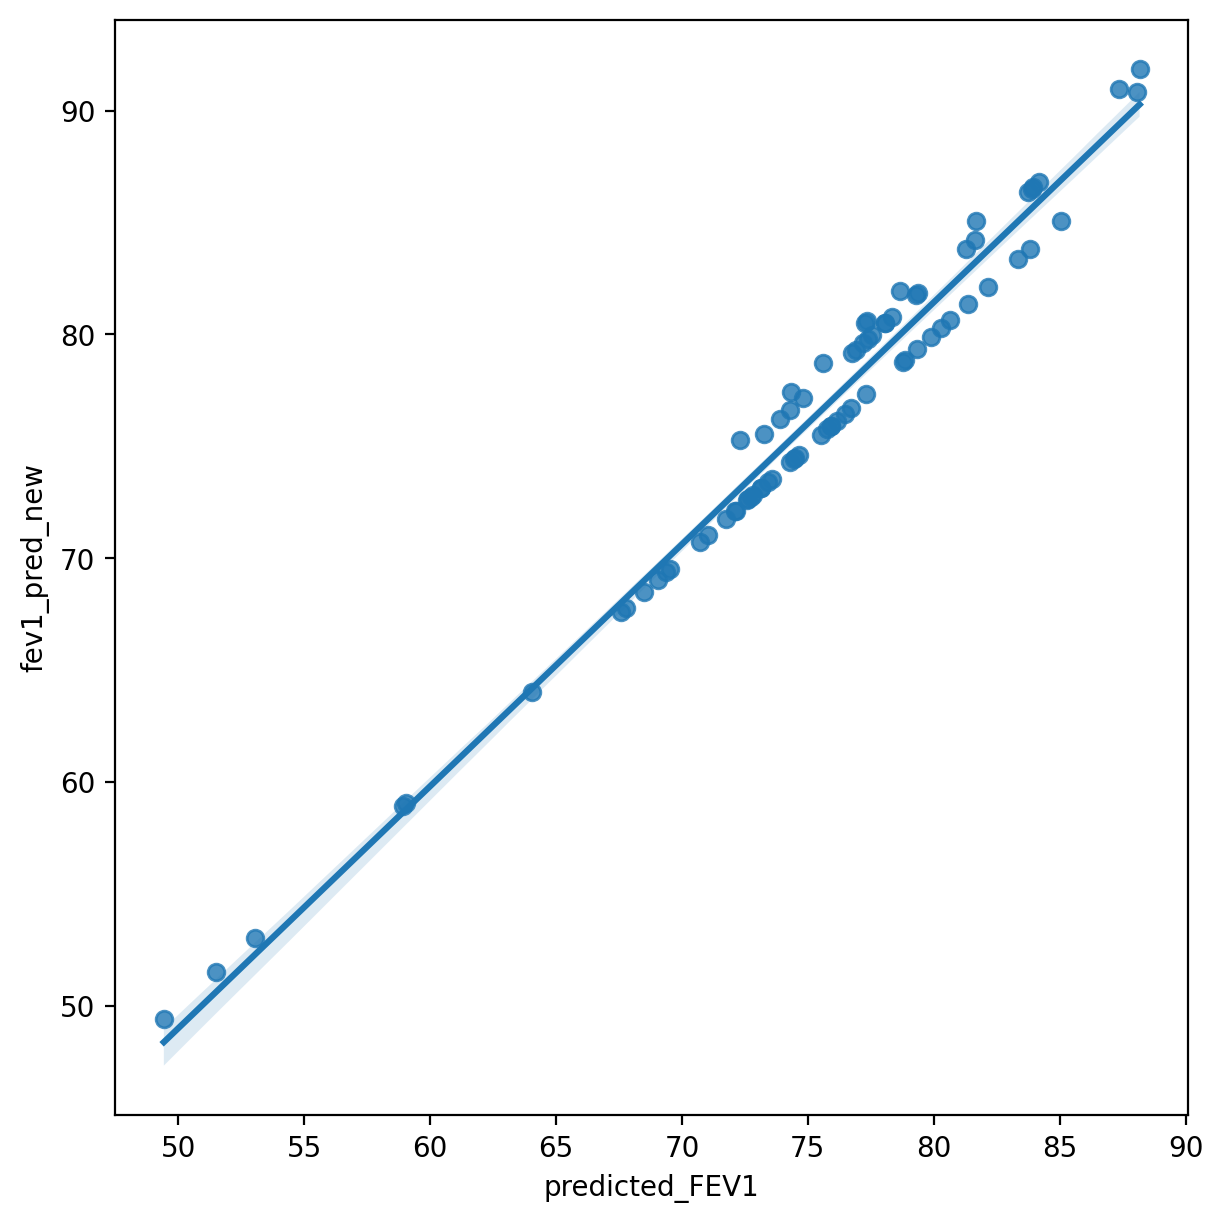

In [25]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
sns.regplot(data=registry, x='predicted_FEV1', y='fev1_pred_new')

<Axes: xlabel='predicted_FVC', ylabel='fvc_pred_new'>

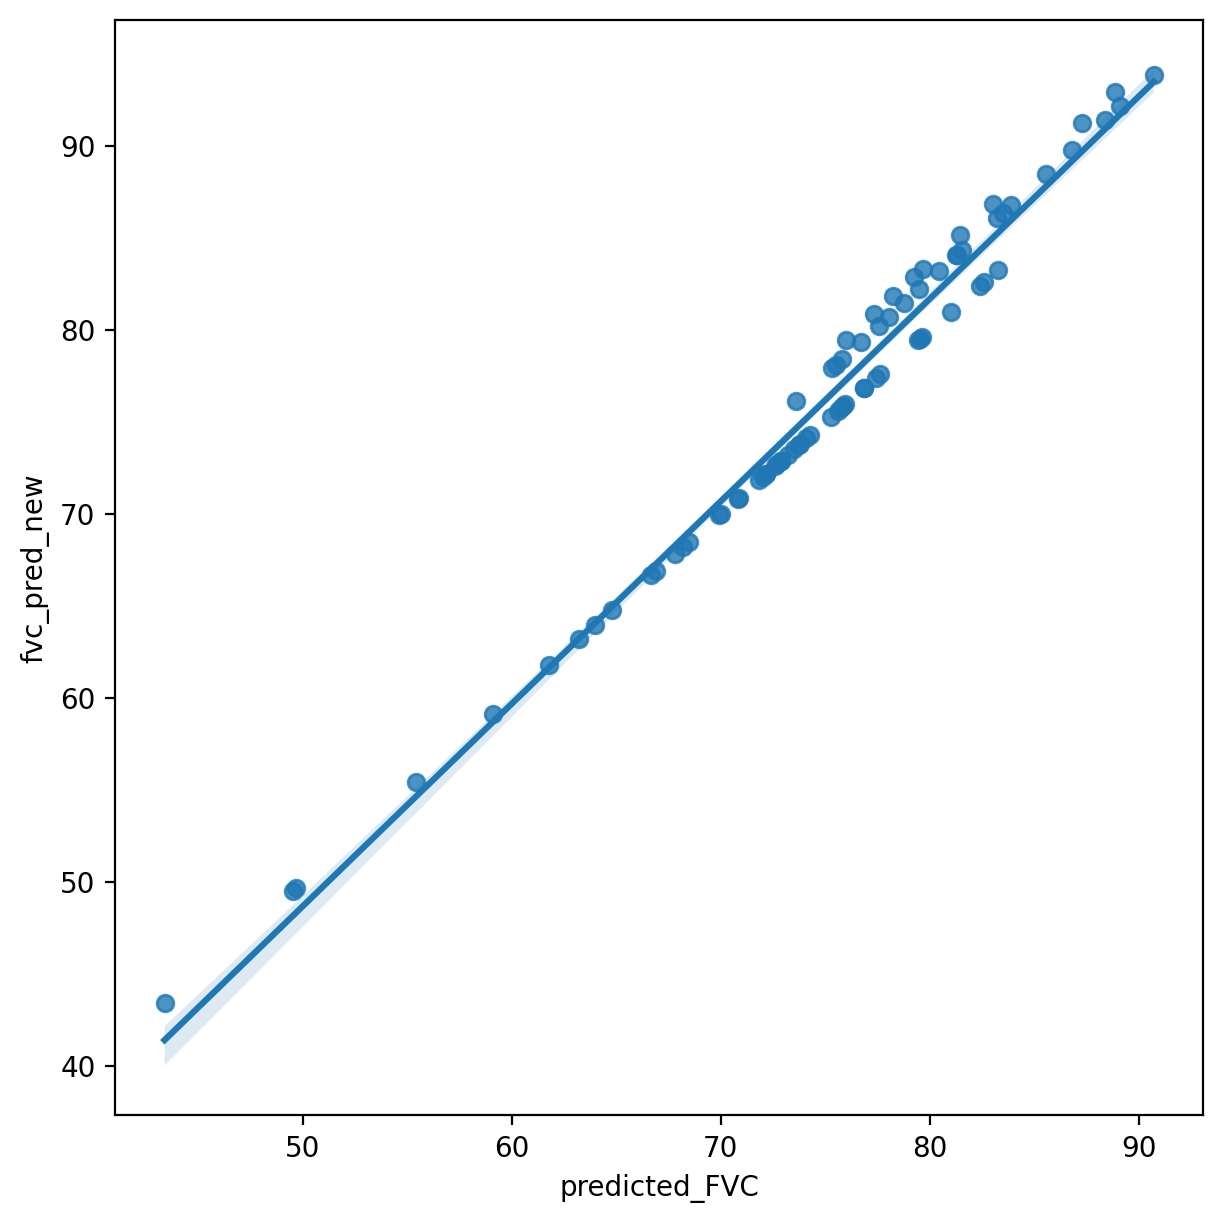

In [26]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
sns.regplot(data=registry, x='predicted_FVC', y='fvc_pred_new')

In [27]:
# fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
# sns.regplot(data=registry, x='predicted_DLCO', y='dlco_pred_new')

Check distributions for batch effect

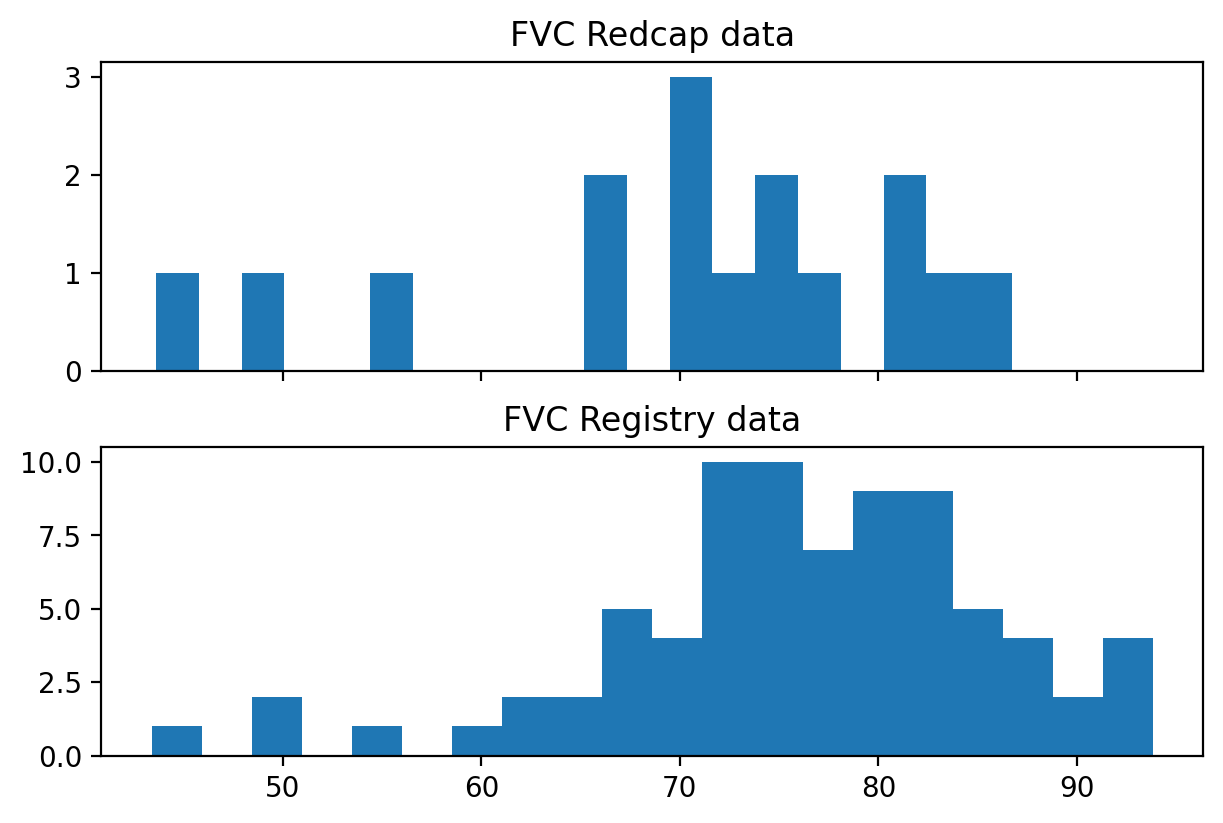

In [28]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(6, 4), constrained_layout=True)
axes[0].hist(clin_info.fvc_pred, bins=20)
axes[1].hist(registry.fvc_pred_new, bins=20)
axes[0].set_title("FVC Redcap data")
axes[1].set_title("FVC Registry data");

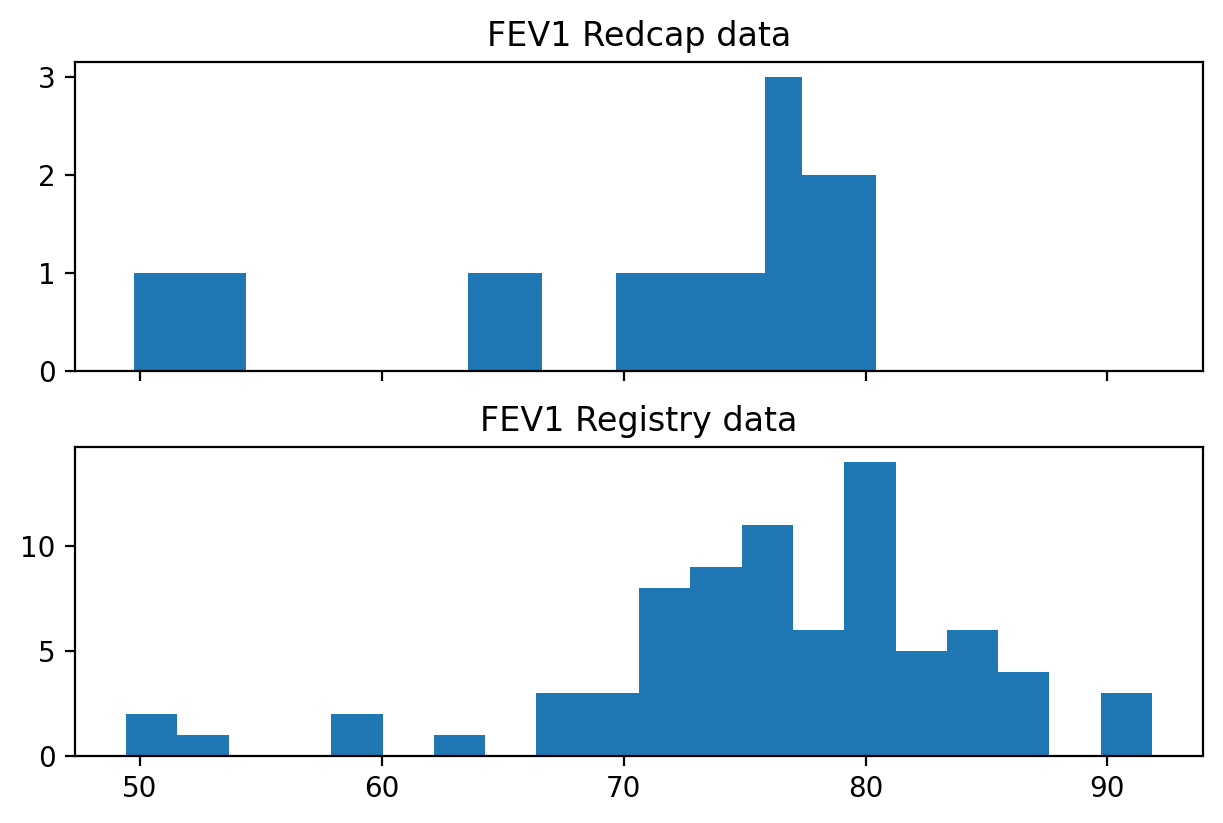

In [29]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(6, 4), constrained_layout=True)
axes[0].hist(clin_info.fev1_pred, bins=20)
axes[1].hist(registry.fev1_pred_new, bins=20)
axes[0].set_title("FEV1 Redcap data")
axes[1].set_title("FEV1 Registry data");

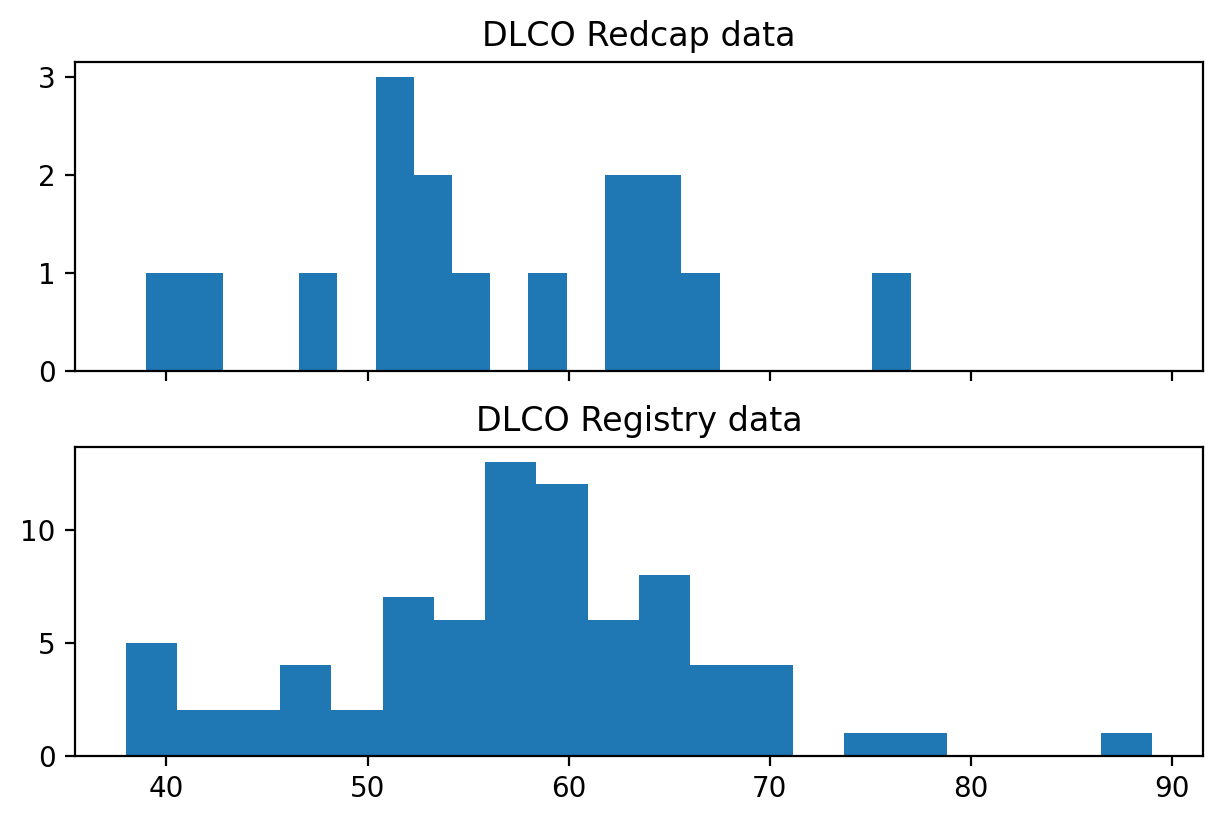

In [30]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(6, 4), constrained_layout=True)
axes[0].hist(clin_info.pft_dlco_pred, bins=20)
axes[1].hist(registry.predicted_DLCO, bins=20)
axes[0].set_title("DLCO Redcap data")
axes[1].set_title("DLCO Registry data");

## 3. Load non-registry data

In [31]:
non_registry = pd.read_csv(os.path.join(data_path, "..", "non_registry_pfts.csv"))
non_registry.drop(columns='Unnamed: 5', inplace=True)

### 3.1 Calculate % predicted

In [32]:
non_registry = non_registry.merge(pt_info, on='study_code', how='left')

In [33]:
non_registry.sex = non_registry.sex.str.lower()

In [34]:
non_registry['year_of_birth_dt'] = pd.to_datetime(
    non_registry.year_of_birth.astype(int).astype(str) + '-01-01'
)
non_registry.year_of_birth_dt = pd.to_datetime(non_registry.year_of_birth_dt)

In [35]:
non_registry.pft_date = pd.to_datetime(non_registry.pft_date)

In [36]:
non_registry['pft_age'] = (non_registry.pft_date - non_registry.year_of_birth_dt).dt.days / 365

In [37]:
non_registry['fev1_pred_new'] = gli_calc.fev1_percent_predicted(
    non_registry.sex.str.lower(),
    non_registry.pft_age,
    non_registry.height,
    non_registry.fev1
)

In [38]:
non_registry['fvc_pred_new'] = gli_calc.fvc_percent_predicted(
    non_registry.sex.str.lower(),
    non_registry.pft_age,
    non_registry.height,
    non_registry.fvc
)

In [39]:
non_registry['dlco_pred_new'] = gli_calc.dlco_percent_predicted(
    non_registry.sex.str.lower(),
    non_registry.pft_age,
    non_registry.height,
    non_registry.dlco
)

In [40]:
non_registry.drop(columns='registry_number', inplace=True)

## 4. Join data

In [41]:
clin_info["registry_number"] = clin_info.study_code.str.extract(r"(\d{4})")

In [42]:
idx = clin_info.registry_number.isna()
clin_info.loc[idx, 'registry_number'] = clin_info.study_code[idx]

In [43]:
data = clin_info[
    ["registry_number", "pft_date", "fvc_pred", "fev1_pred", "pft_dlco_pred", "dlco_ratio"]
].copy()

In [44]:
data['source'] = 'Redcap'

In [45]:
registry = registry.rename(columns={
    "PFT_dts": "pft_date",
    "fvc_pred_new": "fvc_pred",
    "fev1_pred_new": "fev1_pred",
    "predicted_DLCO": "pft_dlco_pred",
    "Ratio": "dlco_ratio"
})

In [46]:
registry['source'] = 'Registry'

In [47]:
non_registry = non_registry.rename(columns={
    'study_code': 'registry_number',
    "fvc_pred_new": "fvc_pred",
    "fev1_pred_new": "fev1_pred",
    "dlco_pred_new": "pft_dlco_pred",
})

In [48]:
non_registry['dlco_ratio'] = np.nan

In [49]:
non_registry['source'] = 'Email'

In [ ]:
data = pd.concat([
    data,
    registry[
        ["registry_number", "pft_date", "fvc_pred", "fev1_pred", "pft_dlco_pred", "dlco_ratio", "source"]
    ],
    non_registry[
        ["registry_number", "pft_date", "fvc_pred", "fev1_pred", "pft_dlco_pred", "dlco_ratio", "source"]
    ]
], ignore_index=True)

In [51]:
data.pft_date = pd.to_datetime(data.pft_date)

In [52]:
data = data.loc[data.pft_date.notna()].copy()

In [53]:
data.sort_values(["registry_number", "pft_date"], inplace=True)

Remove DLCO measurements for bad DLCO tests

In [54]:
data.loc[data.dlco_ratio.lt(0.85), 'pft_dlco_pred'] = np.nan

In [55]:
date_info["registry_number"] = date_info.study_code.str.extract(r"(\d{4})")

In [56]:
idx = date_info.registry_number.isna()
date_info.loc[idx, 'registry_number'] = date_info.study_code[idx]

### 4.1 Manually curate old DLCO value

In [58]:
pt_info.loc[pt_info.registry_number.isna(), 'registry_number'] = pt_info.study_code[pt_info.registry_number.isna()]

In [61]:
data = data.merge(pt_info[['registry_number', 'paper_id']], on='registry_number', how='left')

In [64]:
data = data.loc[~(data.paper_id.eq('SSc_07') & data.source.eq('Redcap'))]

In [69]:
date_info = date_info.merge(pt_info[['registry_number', 'paper_id']], on='registry_number', how='left')

## 5. Plot

In [65]:
pts = data.paper_id.unique()

In [66]:
pts.size

9

### FVC % predicted

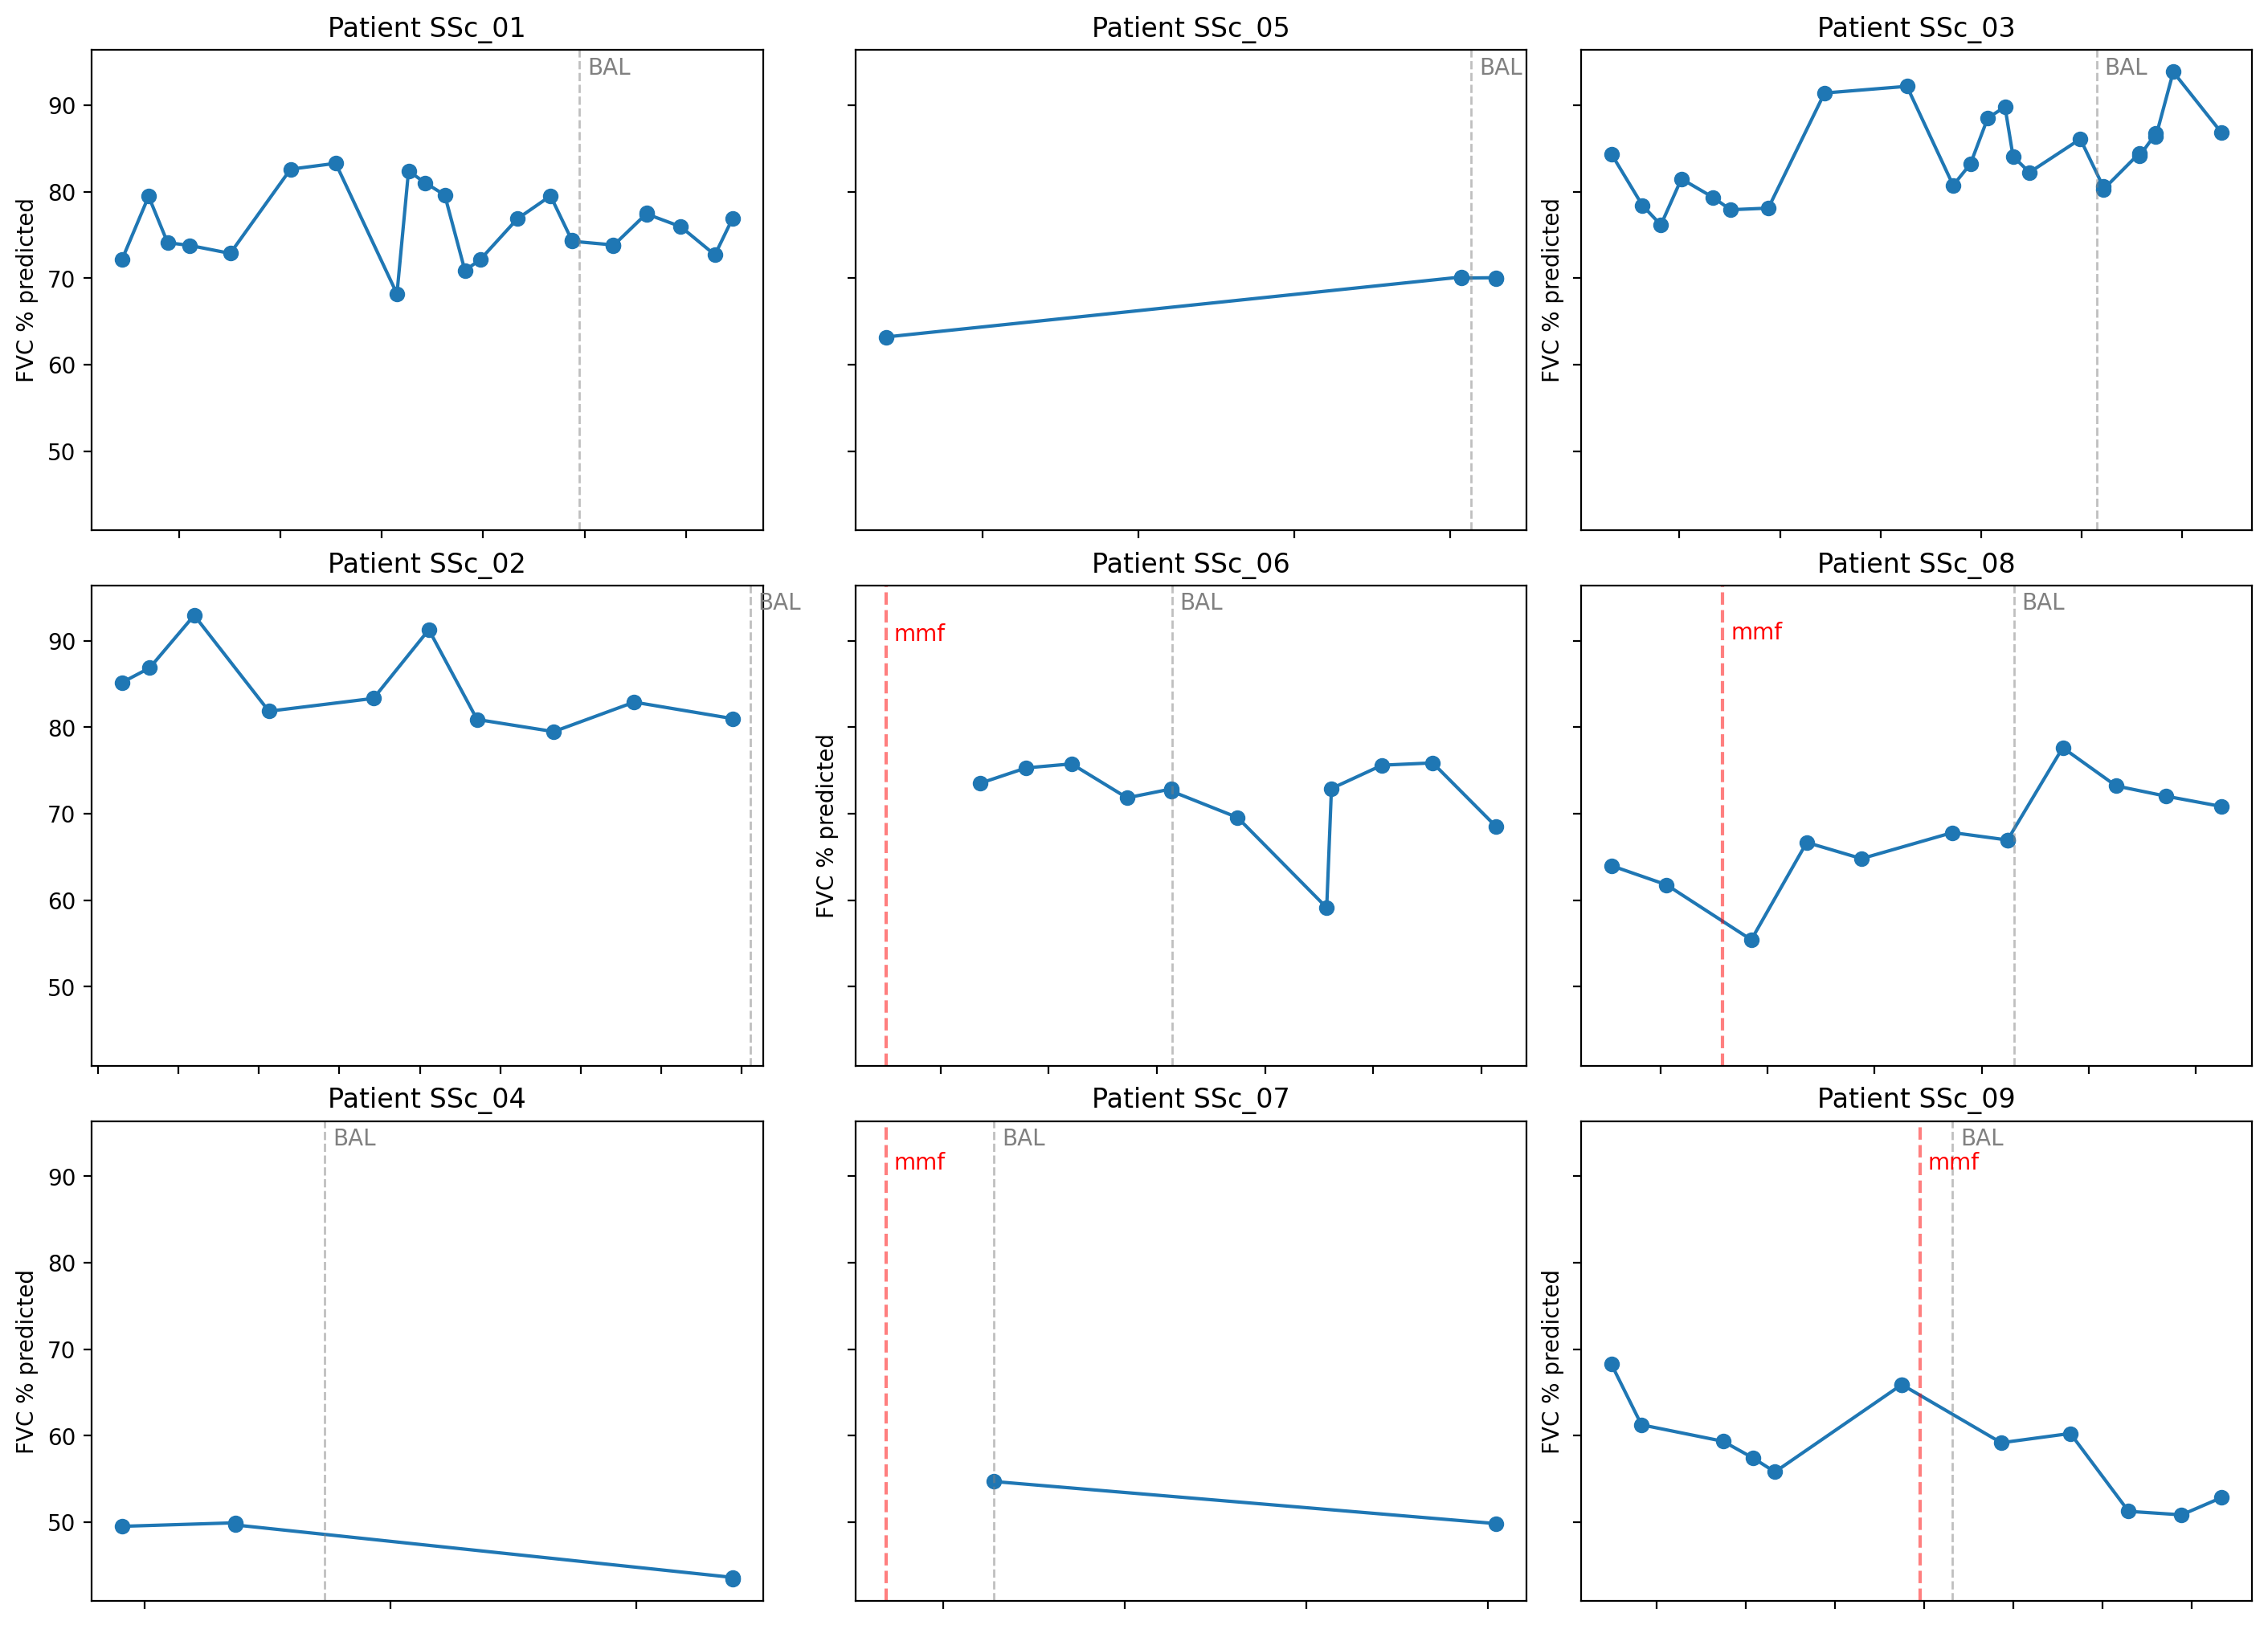

In [ ]:
MAX_YEARS = 8
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, constrained_layout=True, figsize=(14, 10))
for i, pt in enumerate(pts):
    ax = axes[i // 3, i % 3]
    idx = data.paper_id.eq(pt)
    ax.plot(data.pft_date[idx], data.fvc_pred[idx])
    ax.scatter(data.pft_date[idx], data.fvc_pred[idx])
    delta = (data.pft_date[idx].max() - data.pft_date[idx].min()).days / 365
    if delta > MAX_YEARS:
        ax.xaxis.set_major_locator(mpl.dates.YearLocator(3))
    else:
        ax.xaxis.set_major_locator(mpl.dates.YearLocator())
    ax.set_title(f"Patient {pt}")
    if i % 2 == 0:
        ax.set_ylabel("FVC % predicted")
    idx = date_info.event.eq("mmf_bronch_start_date") & date_info.paper_id.eq(pt)
    if idx.sum() > 0:
        val = date_info.date[idx].values[0]
        ax.axvline(x=val, c="red", ls="--", alpha=0.5)
        ax.annotate(
            "mmf",
            (val, ax.get_ylim()[1]),
            xytext=(10, -60),
            textcoords="offset pixels",
            color="red"
        )
    idx = date_info.event.eq("bronch_date") & date_info.paper_id.eq(pt)
    if idx.sum() > 0:
        val = date_info.date[idx].values[0]
        ax.axvline(x=val, c="gray", ls="--", alpha=0.5, lw=1)
        ax.annotate(
            "BAL",
            (val, 1),
            xycoords=("data", "axes fraction"),
            xytext=(10, -30),
            textcoords="offset pixels",
            color="gray"
        )
    # censor years
    ax.tick_params(labelbottom=False)
for i in range(len(pts), axes.size):
    ax = axes[i // 2, i % 2]
    ax.remove()
fig.savefig("plots/03pft-fvc-trends.pdf")

### FEV1 % predicted

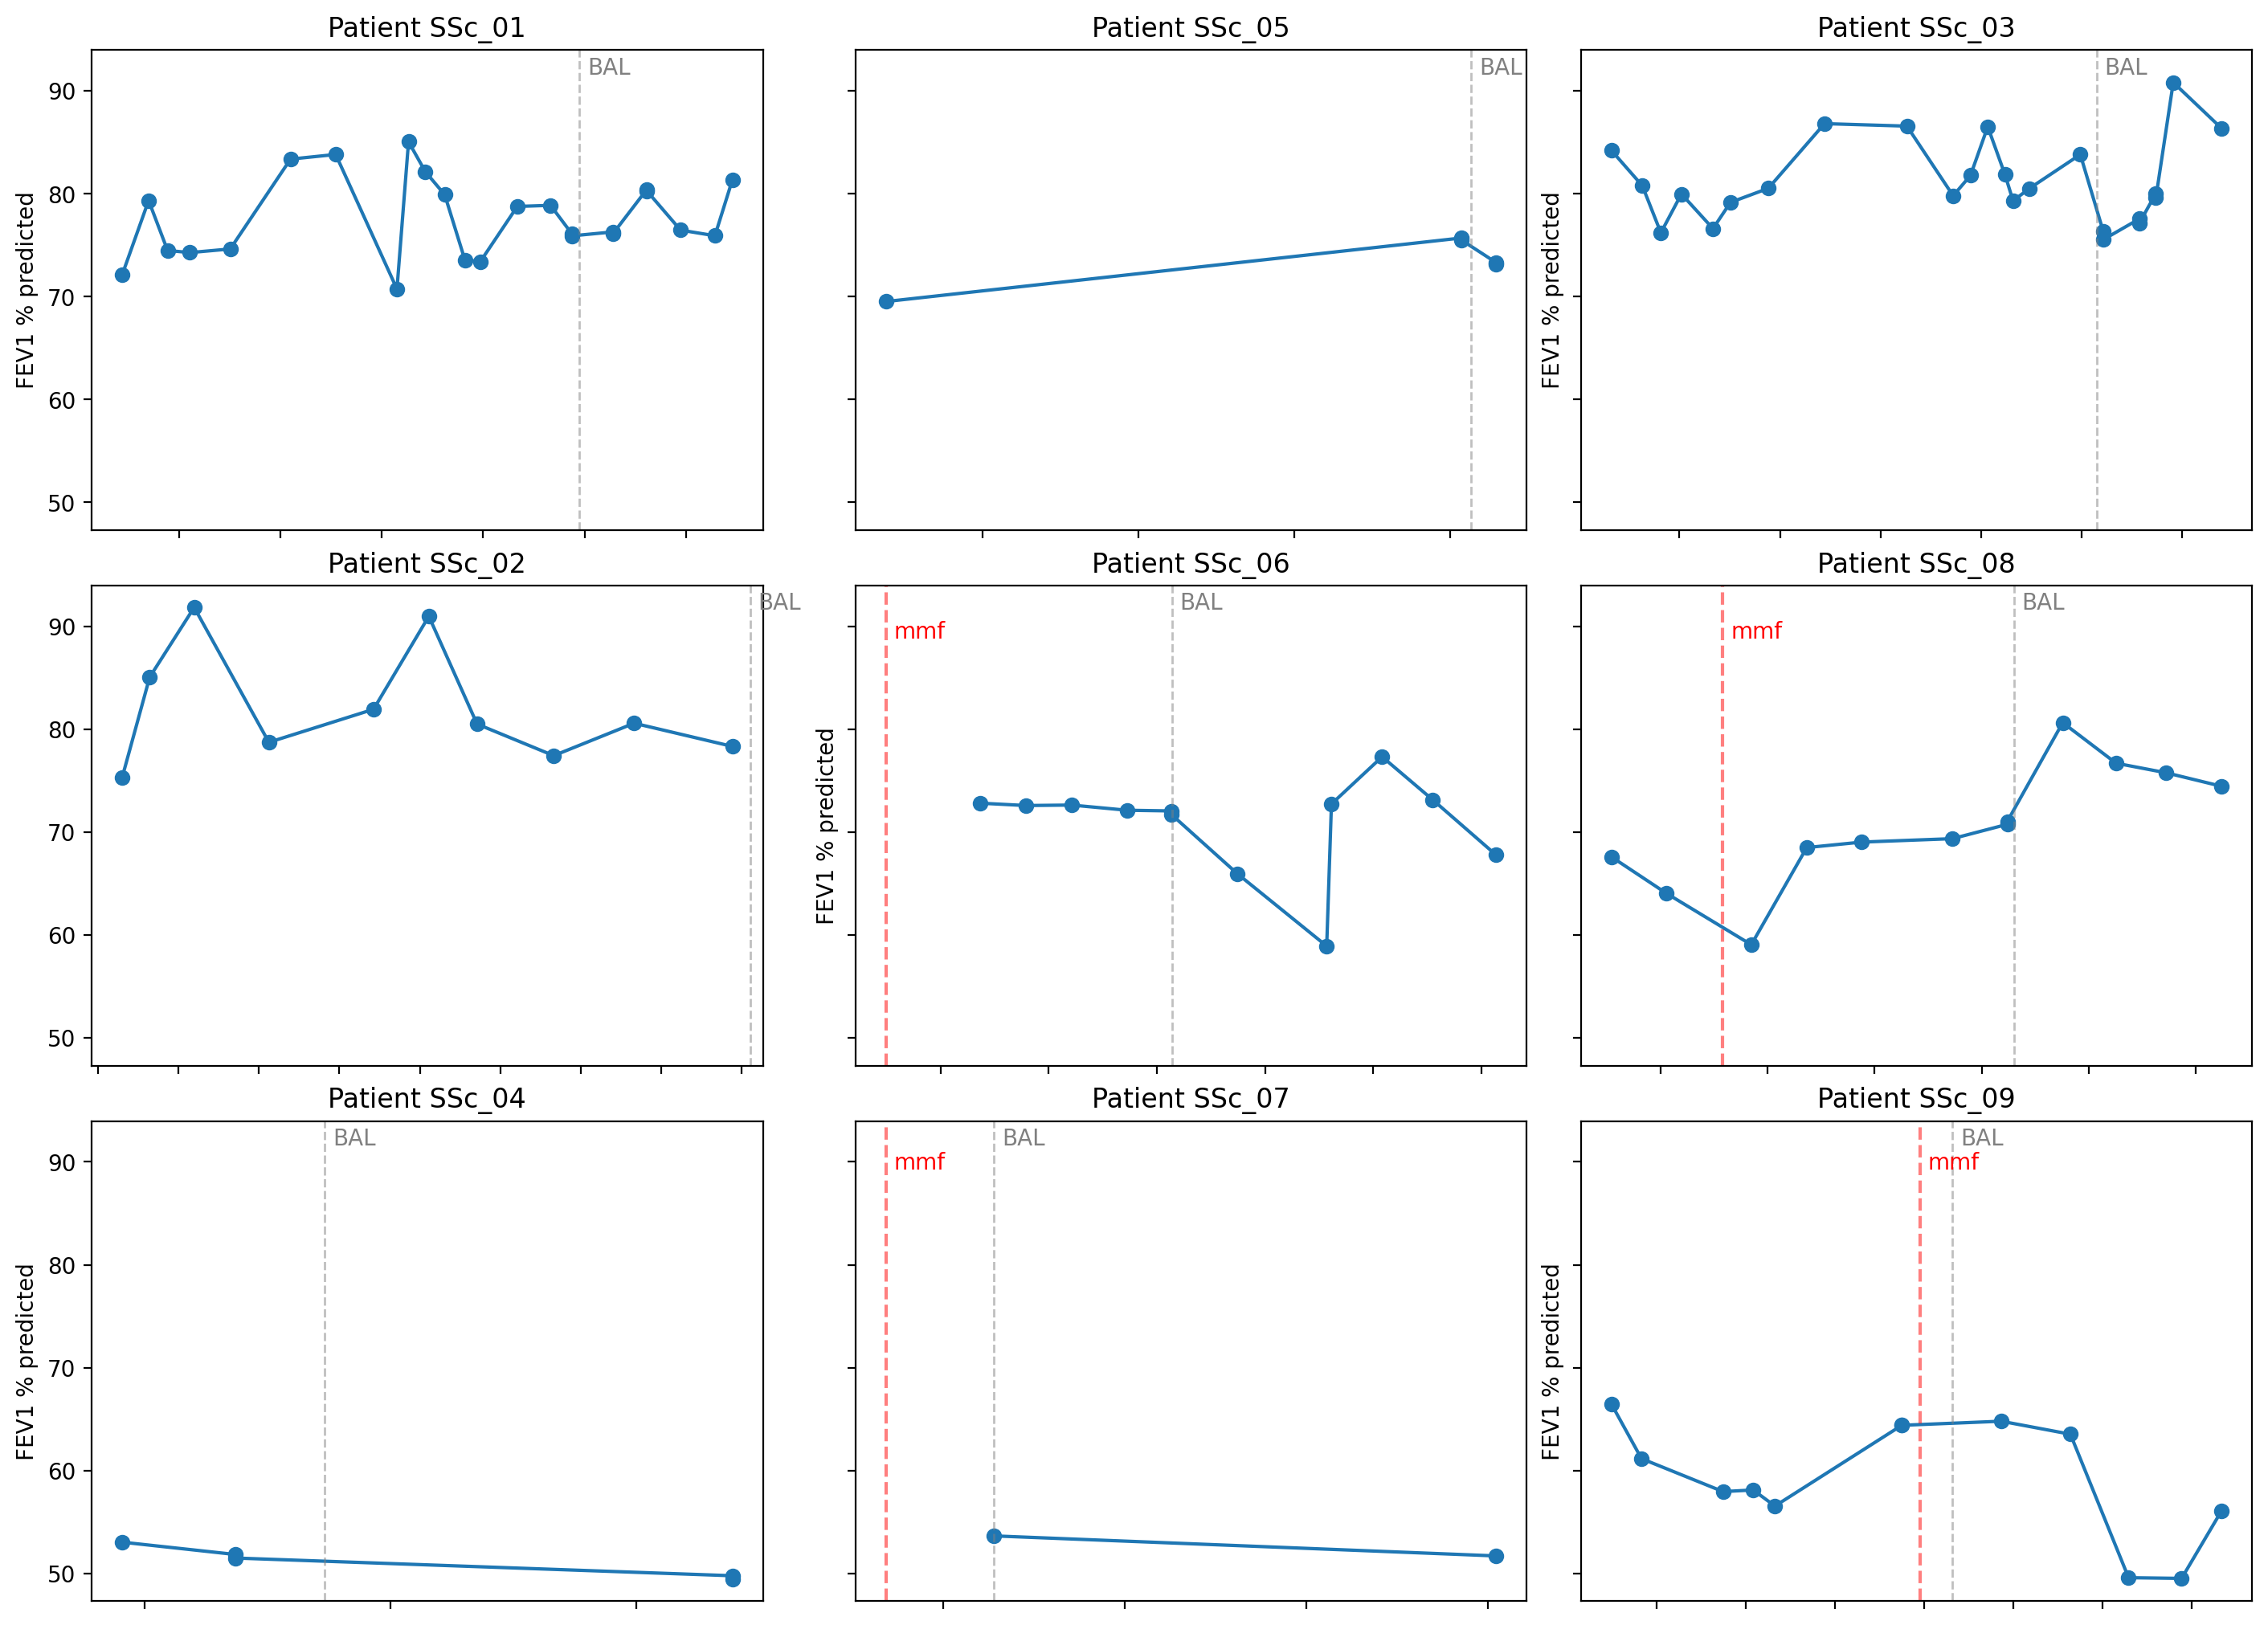

In [ ]:
MAX_YEARS = 8
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, constrained_layout=True, figsize=(14, 10))
for i, pt in enumerate(pts):
    ax = axes[i // 3, i % 3]
    idx = data.paper_id.eq(pt)
    ax.plot(data.pft_date[idx], data.fev1_pred[idx])
    ax.scatter(data.pft_date[idx], data.fev1_pred[idx])
    delta = (data.pft_date[idx].max() - data.pft_date[idx].min()).days / 365
    if delta > MAX_YEARS:
        ax.xaxis.set_major_locator(mpl.dates.YearLocator(3))
    else:
        ax.xaxis.set_major_locator(mpl.dates.YearLocator())
    ax.set_title(f"Patient {pt}")
    if i % 2 == 0:
        ax.set_ylabel("FEV1 % predicted")
    idx = date_info.event.eq("mmf_bronch_start_date") & date_info.paper_id.eq(pt)
    if idx.sum() > 0:
        val = date_info.date[idx].values[0]
        ax.axvline(x=val, c="red", ls="--", alpha=0.5)
        ax.annotate(
            "mmf",
            (val, ax.get_ylim()[1]),
            xytext=(10, -60),
            textcoords="offset pixels",
            color="red"
        )
    idx = date_info.event.eq("bronch_date") & date_info.paper_id.eq(pt)
    if idx.sum() > 0:
        val = date_info.date[idx].values[0]
        ax.axvline(x=val, c="gray", ls="--", alpha=0.5, lw=1)
        ax.annotate(
            "BAL",
            (val, 1),
            xycoords=("data", "axes fraction"),
            xytext=(10, -30),
            textcoords="offset pixels",
            color="gray"
        )
    # censor years
    ax.tick_params(labelbottom=False)
for i in range(len(pts), axes.size):
    ax = axes[i // 2, i % 2]
    ax.remove()
fig.savefig("plots/03pft-fev1-trends.pdf")

### DLCO % predicted

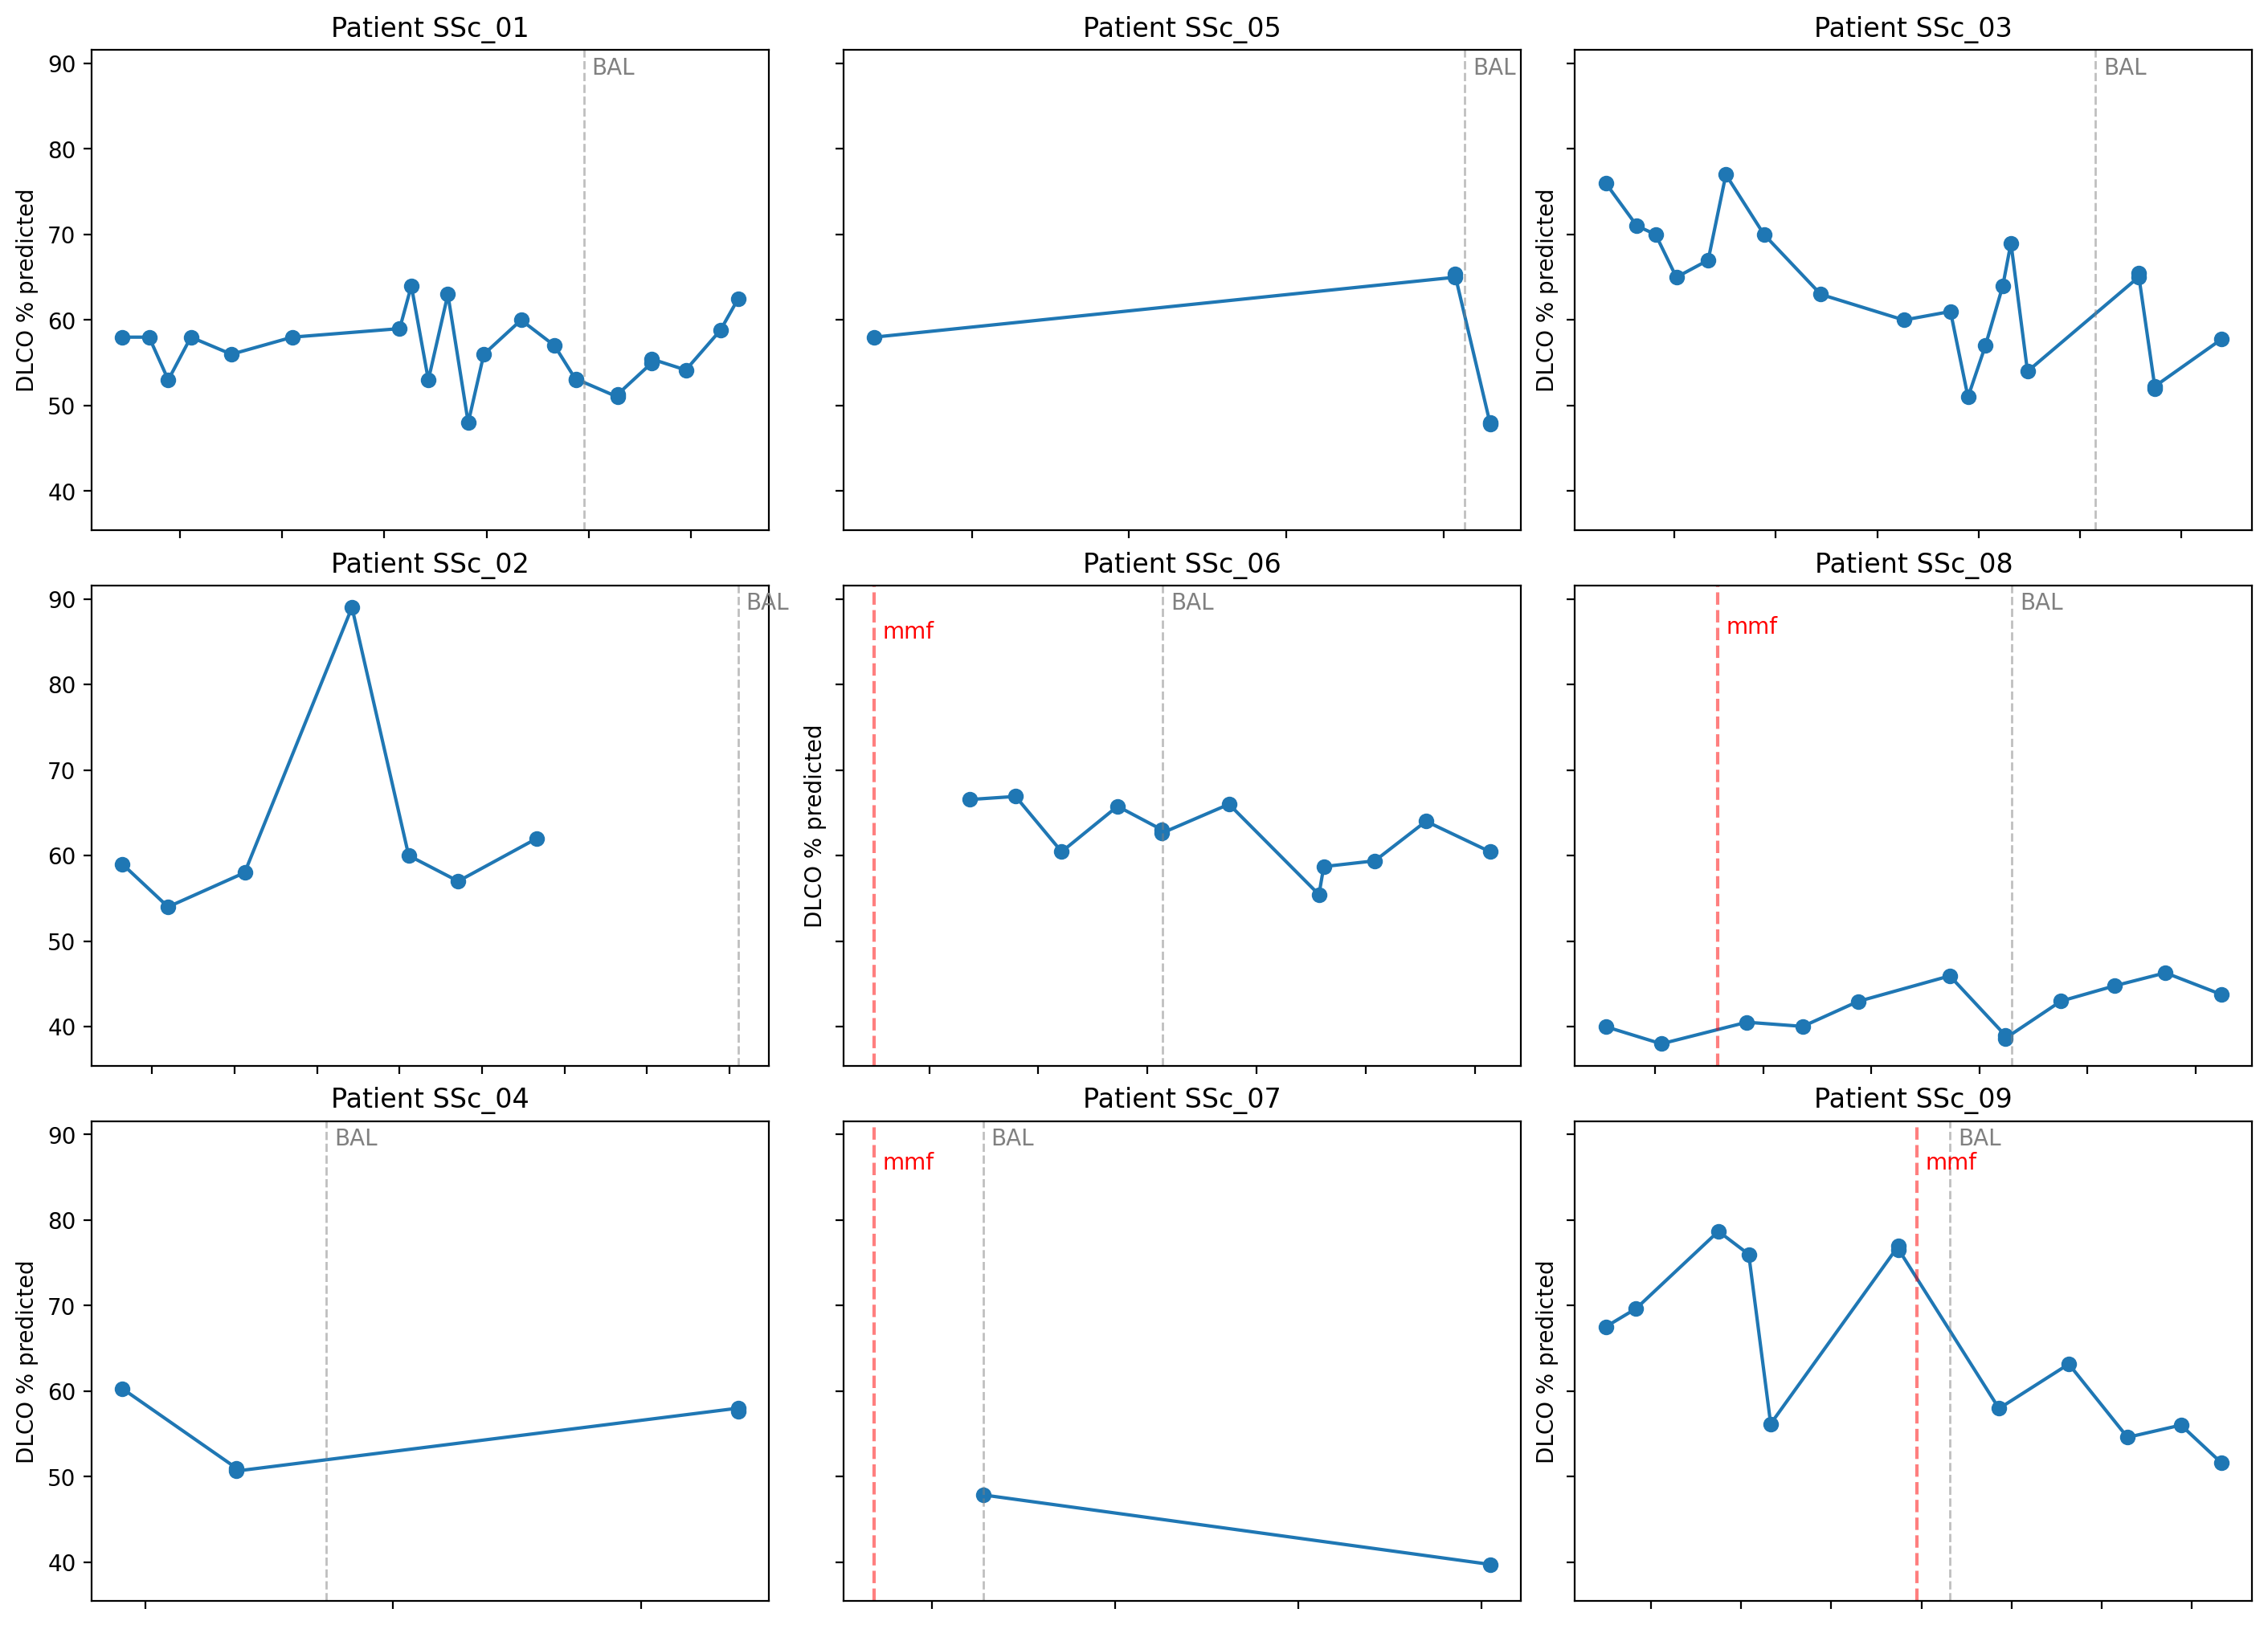

In [ ]:
MAX_YEARS = 8
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, constrained_layout=True, figsize=(14, 10))
for i, pt in enumerate(pts):
    ax = axes[i // 3, i % 3]
    idx = data.paper_id.eq(pt) & data.pft_dlco_pred.notna()
    ax.plot(data.pft_date[idx], data.pft_dlco_pred[idx])
    ax.scatter(data.pft_date[idx], data.pft_dlco_pred[idx])
    delta = (data.pft_date[idx].max() - data.pft_date[idx].min()).days / 365
    if delta > MAX_YEARS:
        ax.xaxis.set_major_locator(mpl.dates.YearLocator(3))
    else:
        ax.xaxis.set_major_locator(mpl.dates.YearLocator())
    ax.set_title(f"Patient {pt}")
    if i % 2 == 0:
        ax.set_ylabel("DLCO % predicted")
    idx = date_info.event.eq("mmf_bronch_start_date") & date_info.paper_id.eq(pt)
    if idx.sum() > 0:
        val = date_info.date[idx].values[0]
        ax.axvline(x=val, c="red", ls="--", alpha=0.5)
        ax.annotate(
            "mmf",
            (val, ax.get_ylim()[1]),
            xytext=(10, -60),
            textcoords="offset pixels",
            color="red"
        )
    idx = date_info.event.eq("bronch_date") & date_info.paper_id.eq(pt)
    if idx.sum() > 0:
        val = date_info.date[idx].values[0]
        ax.axvline(x=val, c="gray", ls="--", alpha=0.5, lw=1)
        ax.annotate(
            "BAL",
            (val, 1),
            xycoords=("data", "axes fraction"),
            xytext=(10, -30),
            textcoords="offset pixels",
            color="gray"
        )
    # censor years
    ax.tick_params(labelbottom=False)
for i in range(len(pts), axes.size):
    ax = axes[i // 2, i % 2]
    ax.remove()
fig.savefig("plots/03pft-dlco-trends.pdf")

## Conclusions

1. We have 4 patients who started MMF (+ 1 from Yale, + 1 in study, 2 in Registry)
2. Only 2 of those patients have PFT before and after starting MMF.